In [1]:
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from model import Model

import utils

import os
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Home device: {}'.format(device))

from matplotlib import pyplot as plt

Home device: cuda:0
Home device: cuda:0


c:\Users\Manley\Documents\CMU\HCL\image


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

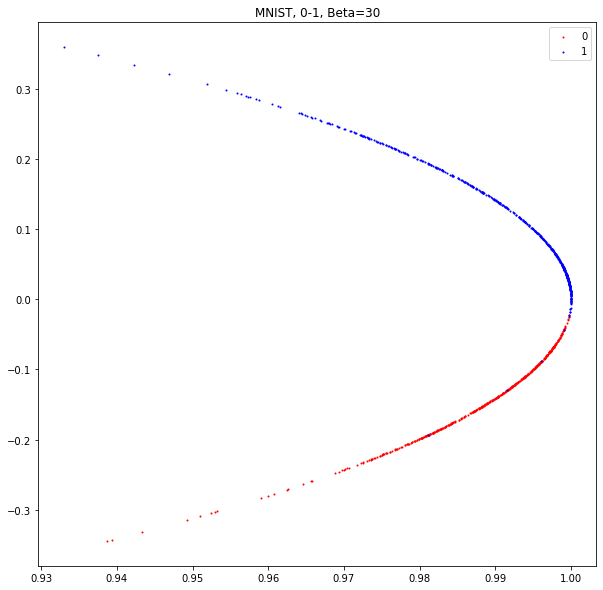

In [22]:

print(os.getcwd())

# betas = [0, 0.5, 1, 3, 10, 30]
betas = [0,30]

paths = [
    f'../results/mnist/mnist_hard_model_64_0.1_{beta:.1f}_10' for beta in betas
]

for path,beta  in zip(paths, betas):
    model_path = path + '.pth'
    batch_size,tau_plus,epoch = 64,0.1,10
    batch_size = 64
    dataset_name = 'mnist'

    train_data, _, test_data = utils.get_dataset(dataset_name, root='../data/', pair=False)
    # train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    model = Model().to(device)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path, map_location='cuda:0'))

    coords = []
    labels = []

    data_loader = test_loader
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device,non_blocking=True), target.to(device,non_blocking=True)
            out = model(data)

            labels.append(target.cpu().numpy())
            normalized_output = out[1].cpu().detach().numpy() / np.linalg.norm(out[1].cpu().detach().numpy(), axis=1, keepdims=True)

            coords.append(normalized_output)

    coords_concatenate = np.concatenate(coords, axis=0)
    labels_concatenate = np.concatenate(labels, axis=0)        

    # for param in model.f.parameters():
    #     param.requires_grad = False
    # model = nn.DataParallel(model)

    plt.clf()
    plt.figure(figsize=(10, 10))

    indices_to_plot = np.random.choice(np.arange(coords_concatenate.shape[0]), size=1000, replace=False)
    for label, color in zip([0,1], ['red','blue']):
        indices_to_plot_now = indices_to_plot[labels_concatenate[indices_to_plot] == label]
        plt.scatter(coords_concatenate[indices_to_plot_now, 0], coords_concatenate[indices_to_plot_now, 1], c=color, label=label, s=1,cmap='viridis')
    plt.title(f'MNIST, 0-1, Beta={beta}')
    plt.legend()
    plt.savefig(f'{path}.png')

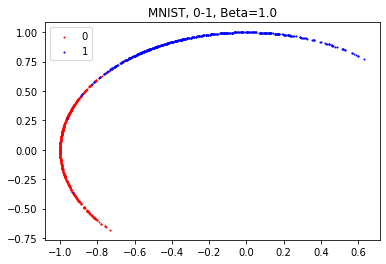

In [11]:
indices_to_plot = np.random.choice(np.arange(coords_concatenate.shape[0]), size=1000, replace=False)
for label, color in zip([0,1], ['red','blue']):
    indices_to_plot_now = indices_to_plot[labels_concatenate[indices_to_plot] == label]
    plt.scatter(coords_concatenate[indices_to_plot_now, 0], coords_concatenate[indices_to_plot_now, 1], c=color, label=label, s=1,cmap='viridis')
plt.title(f'MNIST, 0-1, Beta={beta}')
plt.legend()
plt.savefig(f'{path}.png')